In [1]:
cifar_dir = 'cifar-10-batches-py/'

In [2]:
def unpickle(file):
    import pickle
    with open(file,'rb') as f:
        cifar_dict = pickle.load(f,encoding='bytes')
     
    return cifar_dict

In [3]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [4]:
all_data = [0,1,2,3,4,5,6]

In [5]:
for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(cifar_dir+direc)

In [6]:
batches_meta = all_data[0]
data_batch_1 = all_data[1]
data_batch_2 = all_data[2]
data_batch_3 = all_data[3]
data_batch_4 = all_data[4]
data_batch_5 = all_data[5]
test_batch = all_data[6]

In [7]:
batches_meta

{b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_cases_per_batch': 10000,
 b'num_vis': 3072}

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [9]:
X = data_batch_1[b'data']
X = X.reshape(10000,3,32,32).transpose(0,2,3,1).astype("uint8")
saap = data_batch_1[b'labels']
saap[1]

9

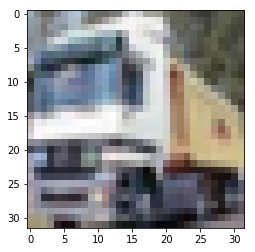

In [10]:
plt.imshow(X[1])

In [11]:
class Cifar_model():
    def __init__(self):
        self.i = 0
        self.training_images = None
        self.training_labels = None
        self.data_batches = [data_batch_1,data_batch_2,data_batch_3,data_batch_4,data_batch_5]
        self.test_images = None
        self.test_labels = None
        self.test_batch = [test_batch]
       
    
    def set_up_images(self):
        print("Setting up training images and labels")
        self.training_images = np.vstack(d[b'data'] for d in self.data_batches)
        self.training_labels = one_hot_encode(np.hstack(d[b'labels'] for d in self.data_batches),10)
        training_len = len(self.training_images)
        self.training_images = self.training_images.reshape(training_len,3,32,32).transpose(0,2,3,1)/255
        
        
        print("Setting up testing images and labels")
        self.test_images = np.vstack(d[b'data'] for d in self.test_batch)
        self.test_labels = one_hot_encode(np.hstack(d[b'labels'] for d in self.test_batch),10)
        testing_len = len(self.test_images)
        self.test_images = self.test_images.reshape(testing_len,3,32,32).transpose(0,2,3,1)/255
        
       
    def next_batch(self,batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(batch_size,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x,y

In [12]:
def one_hot_encode(vec,vals):
    n = len(vec)
    out = np.zeros((n,vals))
    out[range(n),vec] = 1
    return out

In [13]:
ch = Cifar_model()
ch.set_up_images

<bound method Cifar_model.set_up_images of <__main__.Cifar_model object at 0x7f5600995e10>>

In [14]:
import tensorflow as tf

In [15]:
x = tf.placeholder(tf.float32,shape=[None,32,32,3])
y_true = tf.placeholder(tf.float32,shape=[None,10])
hold_prob = tf.placeholder(tf.float32)

In [16]:
def init_weights(shape):
    init_rand_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_rand_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1,shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x,w):
    return tf.nn.conv2d(x,w,strides=[1,1,1,1],padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def conv_layer(input_x,shape):
    w = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, w) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    w = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, w) + b

In [19]:
conv_1 = conv_layer(x,shape=[3,3,3,16])
conv_1_pool = max_pool_2by2(conv_1)

In [20]:
conv_2 = conv_layer(conv_1_pool,shape=[3,3,16,32])
conv_2_pool = max_pool_2by2(conv_2)

In [40]:
conv_3 = conv_layer(conv_2_pool,shape=[2,2,32,64])
conv_3_pool = max_pool_2by2(conv_3)
conv_3_pool.get_shape().as_list()

[None, 4, 4, 64]

In [41]:
4*4*64

1024

In [43]:
conv_3_flat = tf.reshape(conv_3_pool,[-1,4*4*64])#tf.reshape(conv_3_pool,[-1,1024])


In [46]:
affine_layer_1 = tf.nn.relu(normal_full_layer(conv_3_flat,1024))
affine_layer_1.get_shape().as_list()

[None, 1024]

In [48]:
affine_layer_2 = tf.nn.relu(normal_full_layer(affine_layer_1,128))
affine_layer_2.get_shape().as_list()

[None, 128]

In [49]:
drop_out = tf.nn.dropout(affine_layer_2,keep_prob=hold_prob)

In [50]:
y_pred = normal_full_layer(drop_out,10)

In [51]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,logits=y_pred))

In [53]:
optim = tf.train.AdamOptimizer(learning_rate=0.001)

In [54]:
train = optim.minimize(cross_entropy)

In [55]:
init = tf.global_variables_initializer()

In [ ]:
with tf.Session() as sess:
    sess.run(init)
    n_epochs = 2000
    for i in range(n_epochs):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x:batch[0],y:batch[1],hold_prob:0.25})